# Taller Práctico – Detección, Segmentación y Profundidad con YOLO + SAM + MiDaS

Presentado por: [Grupo #7]

- **David Santiago Cruz Hernandez**: dcruzhe@unal.edu.co
- **Sergio Alejandro Reita Serrano**: sreita@unal.edu.co
- **Juan Sebastian Rodriguez Chiquiza**: jurodriguezch@unal.edu.co
- **Fabian Humberto Chaparro Aguilera**: fchaparroa@unal.edu.co

### Importar Librerías

In [54]:
# !pip install -r requirements.txt

In [55]:
from ultralytics import YOLO, SAM
import cv2
import matplotlib.pyplot as plt
import os
import torch
import csv
import numpy as np
import math

### Importar Imagen

In [56]:
img_path = "images/test_image2.jpg"

global img, clases_detectadas, bboxes, masks, depth_map, crops
img = cv2.imread(img_path)

if img is None:
    print("No se pudo cargar la imagen.")

## 1. Detección de Objetos con YOLO
Detectar al menos 2 clases diferentes desde una imagen.

In [57]:
# Cargar modelo YOLOv12 preentrenado
model = YOLO('datos/yolo12n.pt')

In [58]:
def detectar_objetos_yolo(imagen):
    """
    Detecta objetos usando YOLOv12 y devuelve las detecciones.

    Parámetros:
        imagen (np.array): Imagen cargada con OpenCV (BGR).

    Retorna:
        results (list): Lista de resultados de detección.
        detected_classes (set): Conjunto de clases detectadas.
    """
    # Realizar predicción
    results = model(imagen)

    # Obtener nombres de las clases detectadas
    detected_classes = set()
    for r in results:
        for c in r.boxes.cls:
            detected_classes.add(model.names[int(c)])

    return results, detected_classes

### Ejecutar


0: 352x640 3 persons, 3 cars, 4 motorcycles, 3 trucks, 65.7ms
Speed: 2.2ms preprocess, 65.7ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)
Clases detectadas: {'car', 'truck', 'motorcycle', 'person'}


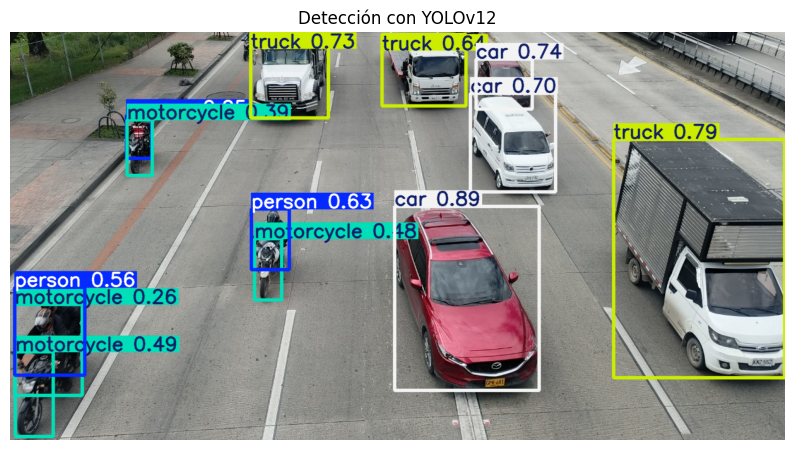

In [59]:
def plot_classes():
    """
    Muestra las clases detectadas en los resultados de YOLO.

    Parámetros:
        results (list): Lista de resultados de detección.
    """
    # Llamar a la función de detección
    global clases_detectadas
    results, clases_detectadas = detectar_objetos_yolo(img)

    # Mostrar resultados
    print("Clases detectadas:", clases_detectadas)

    # Mostrar imagen con detecciones
    annotated_frame = results[0].plot()
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Detección con YOLOv12")
    plt.show()

plot_classes()

## 2. Segmentación con SAM
Usar las bounding boxes de YOLO como prompts para segmentar con SAM.

In [60]:
# Cargar modelo SAM
sam = SAM("datos/sam_b.pt")

In [61]:
from ultralytics.models.sam import Predictor as SAMPredictor

def segmentar_con_sam_usando_bboxes(imagen, bboxes):
    """
    Usa las bounding boxes de YOLO como prompts para SAM.

    Args:
        imagen (np.array): Imagen cargada con OpenCV.
        bboxes (list): Lista de bounding boxes [x1, y1, x2, y2]

    Returns:
        masks: Máscaras de segmentación resultantes.
    """
    predictor = SAMPredictor(overrides=dict(model="datos/sam_b.pt", imgsz=1024))
    predictor.set_image(imagen)  # Codifica la imagen una vez

    masks_list = []
    for bbox in bboxes:
        results = predictor(bboxes=bbox)
        masks_list.append(results[0].masks.data)  # Obtener máscara segmentada

    return masks_list

### Ejecutar


0: 352x640 3 persons, 3 cars, 4 motorcycles, 3 trucks, 67.5ms
Speed: 1.7ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)
Clases detectadas: {'car', 'truck', 'motorcycle', 'person'}
Ultralytics 8.3.160  Python-3.12.9 torch-2.7.1+cpu CPU (AMD Ryzen 7 3700X 8-Core Processor)

0: 1024x1024 1 0, 54.7ms
Speed: 13.6ms preprocess, 54.7ms inference, 2.7ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict

0: 1024x1024 1 0, 50.2ms
Speed: 8.6ms preprocess, 50.2ms inference, 2.7ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict

0: 1024x1024 1 0, 49.2ms
Speed: 9.4ms preprocess, 49.2ms inference, 2.9ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict

0: 1024x1024 1 0, 47.8ms
Speed: 9.1ms preprocess, 47.8ms inference, 2.7ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs\segment\predict

0: 1024x1024 1 0, 50.0ms
Speed: 8.

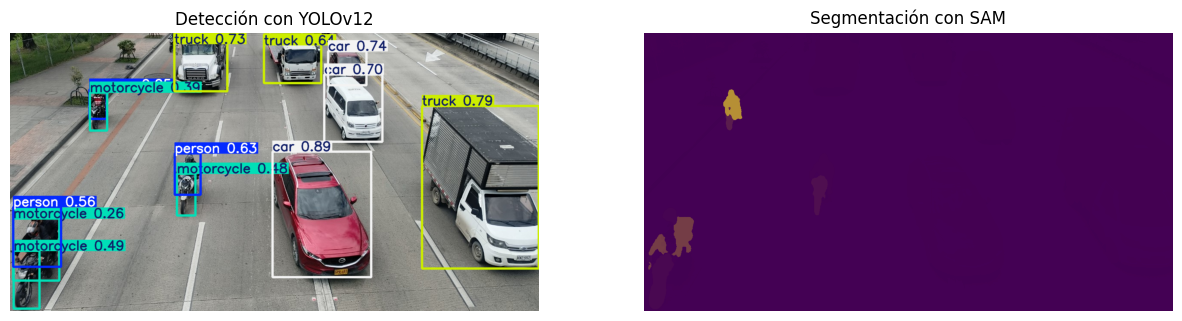

In [62]:
def plot_segmentacion():
    """
    Realiza la segmentación de objetos usando SAM con las bounding boxes de YOLO.
    """
    global img  # Asegurarse de que img esté disponible
    global bboxes

    results, clases_detectadas = detectar_objetos_yolo(img)
    bboxes = results[0].boxes.xyxy.tolist()

    # Mostrar resultados
    print("Clases detectadas:", clases_detectadas)

    # Segmentación con SAM usando las bboxes como prompt
    global masks
    masks = segmentar_con_sam_usando_bboxes(img, bboxes)

    # Mostrar resultado final
    annotated_img = results[0].plot()  # Detecciones YOLO
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title("Detección con YOLOv12")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for mask in masks:
        plt.imshow(mask[0].cpu().numpy(), alpha=0.5, cmap='viridis')  # Mostrar máscaras
    plt.title("Segmentación con SAM")
    plt.axis('off')

    plt.show()

plot_segmentacion()

## 3. Estimación de Profundidad con MiDaS
Generar un mapa de profundidad con el modelo MiDaS (usa v3.1).


In [63]:
# Cargar modelo MiDaS desde Torch Hub (Intel DPT-Large Hybrid)
model_type = "DPT_Hybrid"  # Opciones: DPT_Large, DPT_Hybrid, MiDaS_small
midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo='check')

midas.to("cpu")
midas.eval()

# Cargar transformaciones de MiDaS
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

Using cache found in C:\Users\S4N/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\S4N/.cache\torch\hub\intel-isl_MiDaS_master


In [64]:
def estimar_profundidad_midas():
    """
    Genera un mapa de profundidad usando MiDaS v3.1.

    Args:
        imagen (np.array): Imagen cargada con OpenCV (BGR).

    Returns:
        depth_map (np.array): Mapa de profundidad normalizado (0-1).
    """
    global img

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_batch = transform(img_rgb).to("cpu")

    with torch.no_grad():
        prediction = midas(input_batch)

        # Interpolar resultado al tamaño original
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img_rgb.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    global depth_map
    depth_map = prediction.cpu().numpy()
    depth_map = cv2.normalize(depth_map, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return depth_map

### Ejecutar


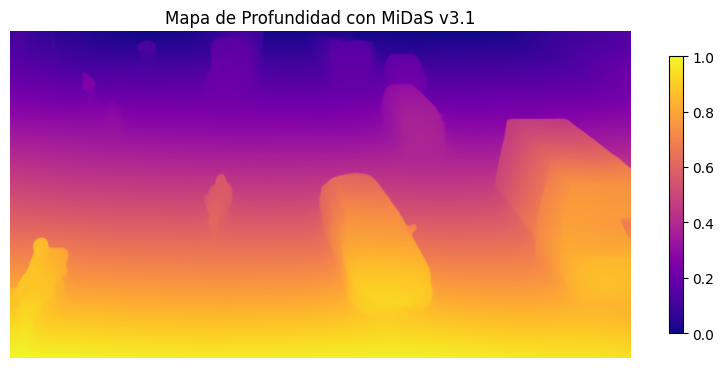

In [65]:
def plot_depth_map():
    """
    Genera y muestra el mapa de profundidad usando MiDaS v3.1.
    """

    # Estimar profundidad
    depth_map = estimar_profundidad_midas()

    # Mostrar mapa de profundidad
    plt.figure(figsize=(10, 6))
    plt.imshow(depth_map, cmap='plasma')
    plt.title("Mapa de Profundidad con MiDaS v3.1")
    plt.axis('off')
    plt.colorbar(shrink=0.6)
    plt.show()

plot_depth_map()

## 4. Visualización Combinada
Imagen original con cajas, máscaras y mapa de profundidad.
Recortes individuales de objetos con fondo blanco.
Mapa de profundidad en escala de grises o heatmap.

In [66]:
def visualizar_resultados(imagen, boxes, masks, depth_map):
    """
    Visualiza resultados combinados: detección, segmentación y profundidad.

    Args:
        imagen (np.array): Imagen original (BGR).
        boxes (list): Lista de bounding boxes [x1, y1, x2, y2].
        masks (list): Lista de máscaras (torch.Tensor o np.array).
        depth_map (np.array): Mapa de profundidad normalizado (0-1).
    """
    # 1. Imagen original con cajas y máscaras
    img_vis = imagen.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        color = (0, 255, 0)
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), color, 2)
        if masks and i < len(masks):
            mask = masks[i][0].cpu().numpy() if hasattr(masks[i][0], 'cpu') else masks[i][0]
            mask = (mask > 0.5).astype(np.uint8)
            color_mask = np.zeros_like(img_vis)
            color_mask[mask == 1] = [0, 0, 255]
            img_vis = cv2.addWeighted(img_vis, 1, color_mask, 0.5, 0)

    # 2. Recortes individuales con fondo blanco
    global crops
    crops = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        crop = np.ones((y2 - y1, x2 - x1, 3), dtype=np.uint8) * 255
        if masks and i < len(masks):
            mask = masks[i][0].cpu().numpy() if hasattr(masks[i][0], 'cpu') else masks[i][0]
            mask = (mask > 0.5).astype(np.uint8)
            obj = imagen[y1:y2, x1:x2]
            mask_crop = mask[y1:y2, x1:x2]
            crop[mask_crop == 1] = obj[mask_crop == 1]
        crops.append(crop)

     # 3. Visualización
    num_crops = len(crops)
    crop_cols = 3
    crop_rows = math.ceil(num_crops / crop_cols)
    total_cols = max(3, crop_cols)
    total_rows = 2 + crop_rows

    plt.figure(figsize=(4 * total_cols, 4 * total_rows))

    # Fila 1: Imagen original + profundidad
    plt.subplot(total_rows, total_cols, 1)
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.title("Detección + Segmentación")
    plt.axis('off')

    plt.subplot(total_rows, total_cols, 2)
    plt.imshow(depth_map, cmap='gray')
    plt.title("Profundidad (Grises)")
    plt.axis('off')

    plt.subplot(total_rows, total_cols, 3)
    plt.imshow(depth_map, cmap='plasma')
    plt.title("Profundidad (Heatmap)")
    plt.axis('off')

    # Fila(s) 2+: Recortes individuales
    for i, crop in enumerate(crops):
        row = 2 + i // crop_cols
        col = i % crop_cols + 1
        index = (row - 1) * total_cols + col
        plt.subplot(total_rows, total_cols, index)
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Objeto {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('outputs/resultados.png')
    plt.show()


### Ejecutar

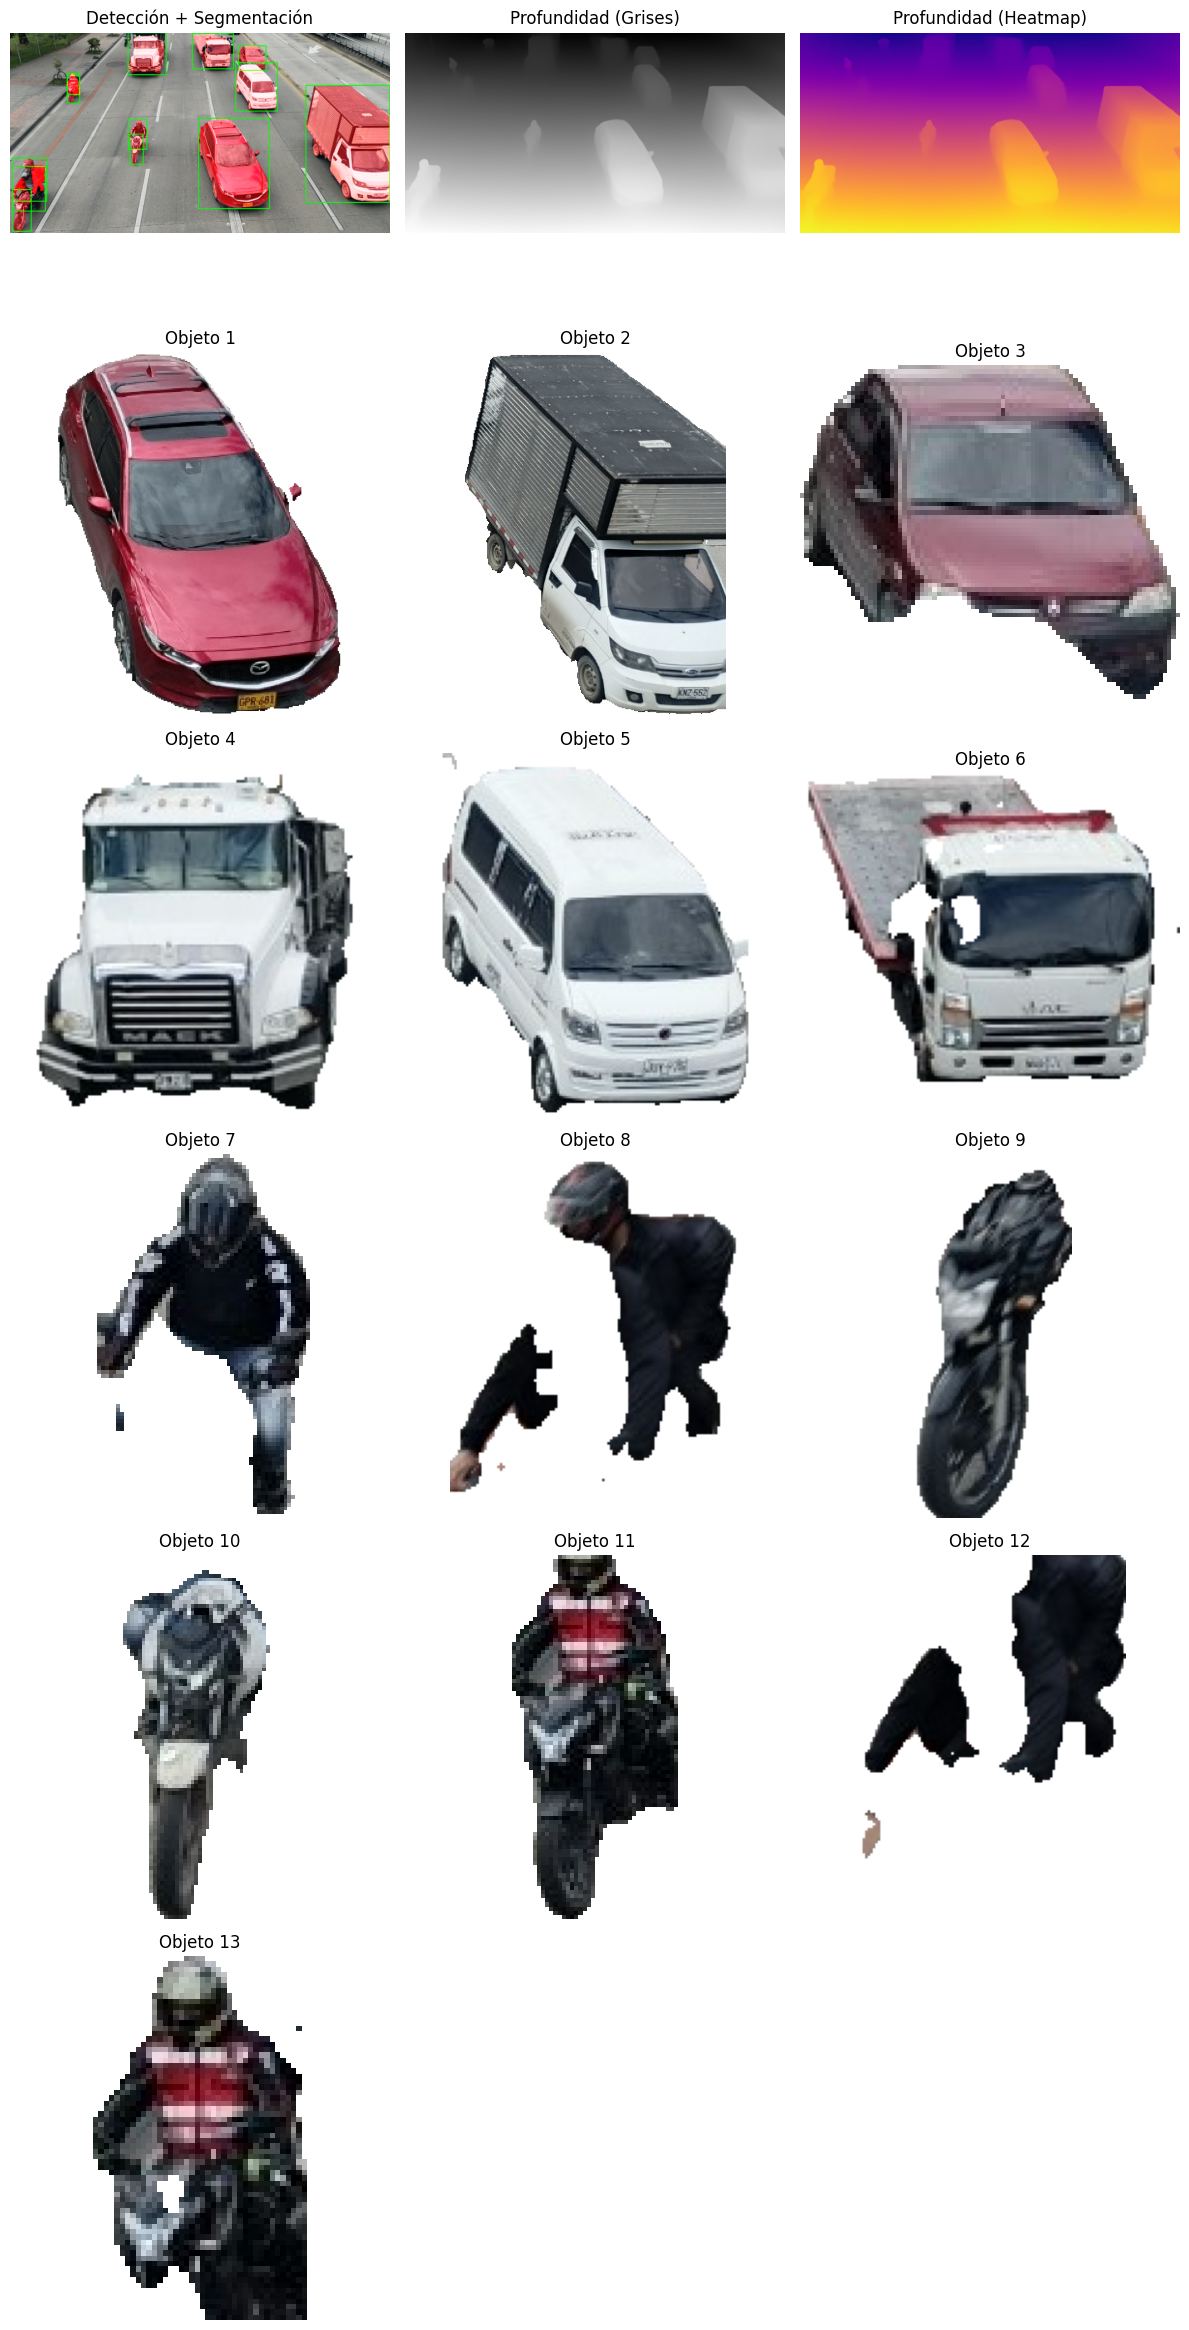

In [67]:
visualizar_resultados(img, bboxes, masks, depth_map)

## Exportar Resultados

### Guardar Imágenes y Máscaras

In [68]:
def save_results():
    """
    Guarda los resultados de detección, segmentación y profundidad en archivos.
    """

    # Crear carpetas si no existen
    os.makedirs('outputs', exist_ok=True)
    os.makedirs('outputs/depth_maps', exist_ok=True)
    os.makedirs('outputs/recortes', exist_ok=True)
    os.makedirs('outputs/segmentaciones', exist_ok=True)

    # Guardar mapa de profundidad
    cv2.imwrite('outputs/depth_maps/depth_map.png', (depth_map * 255).astype('uint8'))

    # Guardar recortes individuales
    for i, crop in enumerate(crops):
        cv2.imwrite(f'outputs/recortes/objeto_{i+1}.png', crop)

    # Guardar máscaras de segmentación
    for i, mask in enumerate(masks):
        mask_img = (mask[0].cpu().numpy() * 255).astype('uint8')
        cv2.imwrite(f'outputs/segmentaciones/mask_{i+1}.png', mask_img)

save_results()

## 5. Aplicación Analítica o Creativa
### Guardar Bounding Boxes y Máscaras en CSV

In [69]:
def analizar_segmentaciones_con_profundidad(masks, clases, bboxes, depth_map, csv_path='outputs/analisis_objetos.csv'):
    """
    Exporta un CSV con clase, bounding box y profundidad promedio de cada objeto.

    Args:
        masks (list): Máscaras de segmentación (torch.Tensor o np.array).
        clases (list): Lista de nombres de clases detectadas.
        bboxes (list): Lista de bounding boxes [x1, y1, x2, y2].
        depth_map (np.array): Mapa de profundidad normalizado (0-1).
        csv_path (str): Ruta de guardado del CSV.
    """
    rows = []
    for i, mask in enumerate(masks):
        mask_np = mask[0].cpu().numpy() if hasattr(mask[0], 'cpu') else mask[0]
        mask_bin = (mask_np > 0.5)

        # Profundidad promedio solo donde la máscara es 1
        mean_depth = float(depth_map[mask_bin].mean()) if mask_bin.any() else 0.0
        clases = list(clases)
        clase = clases[i] if i < len(clases) else 'desconocido'
        bbox = bboxes[i] if i < len(bboxes) else [0,0,0,0]
        rows.append({
            'clase': clase,
            'bbox': bbox,
            'profundidad_promedio': mean_depth
        })

    # Guardar en CSV
    with open(csv_path, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['clase', 'bbox', 'profundidad_promedio'])
        writer.writeheader()
        for row in rows:
            writer.writerow(row)

analizar_segmentaciones_con_profundidad(masks, clases_detectadas, bboxes, depth_map)